DialogSum data used for performing evaluation on BART model and fine- tuning using Optuna.

In [ ]:
pip install datasets

In [ ]:
from datasets import load_dataset
dataset_dialog = load_dataset("knkarthick/dialogsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
print(dataset_dialog)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


In [ ]:
dataset_dialog['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [ ]:
def find_duplicates(dataset, column_name):
    duplicates = dataset.filter(lambda example: dataset[column_name].count(example[column_name]) > 1)
    return duplicates

In [ ]:
test_dataset= dataset_dialog['test']

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_summary_batch(record):
    input_texts = record['dialogue']
    input_ids = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids = input_ids['input_ids'].to(device)

    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)

    summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in output_ids]
    return {"generated_summary": summaries}

batch_size = 8
test_dataset = test_dataset.map(generate_summary_batch, batched=True, batch_size=batch_size)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
test_dataset


Dataset({
    features: ['id', 'dialogue', 'summary', 'topic', 'generated_summary'],
    num_rows: 1500
})

In [ ]:

'''
def generate_summary(record):
    input_ids = tokenizer.encode("summarize: " + record['dialogue'], return_tensors="pt", max_length=max_input_length, truncation=True)
    output_ids = model.generate(input_ids, max_length=max_output_length, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return {"generated_summary": summary}

dataset_dialog = dataset_dialog.map(generate_summary)
!pip install rouge-score
'''

'\ndef generate_summary(example):\n    input_ids = tokenizer.encode("summarize: " + example[\'dialogue\'], return_tensors="pt", max_length=max_input_length, truncation=True)\n    output_ids = model.generate(input_ids, max_length=max_output_length, num_beams=4, early_stopping=True)\n    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)\n    return {"generated_summary": summary}\n\ndataset_dialog = dataset_dialog.map(generate_summary)\n!pip install rouge-score\n'

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fc15d2dc43bb880794658023c6fb59b6012d6a1980d19839a0df61c23096b776
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install bert_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

#calculate evaluation metrics
def calculate_metrics(reference, hypothesis):
    metrics = {}

    #tokenizing the  reference and summaries for METEOR and BLEU
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    smooth_fn = SmoothingFunction().method1
    metrics['BLEU'] = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1']= rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2']= rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L']= rouge_scores['rougeL'].fmeasure
    metrics['METEOR']= meteor_score([reference_tokens], hypothesis_tokens)
    '''
    # BERTScore
    P, R, F1 = bert_score([hypothesis], [reference], lang="en")
    metrics['BERTScore']= F1.mean().item()
    '''
    P, R, F1 = bert_score([hypothesis], [reference], lang='en', model_type='bert-base-uncased', verbose=False)
    metrics['BERTScore_P'] = P.mean().item()
    metrics['BERTScore_R'] = R.mean().item()
    metrics['BERTScore_F1'] = F1.mean().item()

    vectorizer =TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors =vectorizer.toarray()
    cosine_sim =cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]

    return metrics

test_results = test_dataset.map(lambda record: calculate_metrics(record['summary'], record['generated_summary']))

import pandas as pd
results_df = pd.DataFrame(test_results)
print(f"Evaluation Metrics for BART Model\n")
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Evaluation Metrics for BART Model

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.023735     0.187511     0.052275     0.135653     0.291310   
std       0.020063     0.063463     0.046460     0.050008     0.084932   
min       0.001678     0.036697     0.000000     0.027778     0.062500   
25%       0.012702     0.141732     0.017857     0.102564     0.232821   
50%       0.016607     0.181818     0.043637     0.128506     0.281943   
75%       0.027973     0.223881     0.076336     0.161765     0.340399   
max       0.181969     0.455696     0.337662     0.430380     0.688164   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.211664     0.435580     0.631429      0.513800  
std             0.095620     0.059895     0.064770      0.058373  
min             0.030719     0

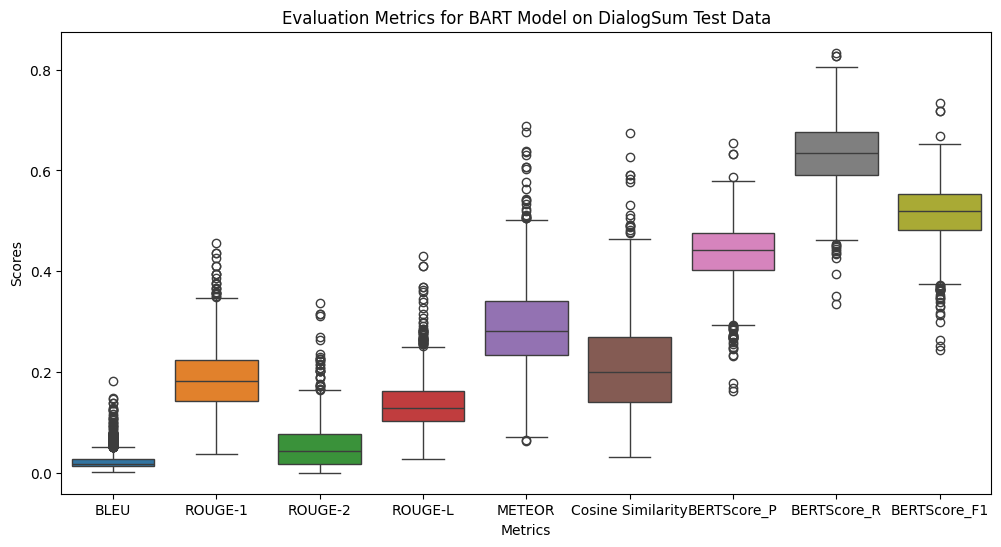

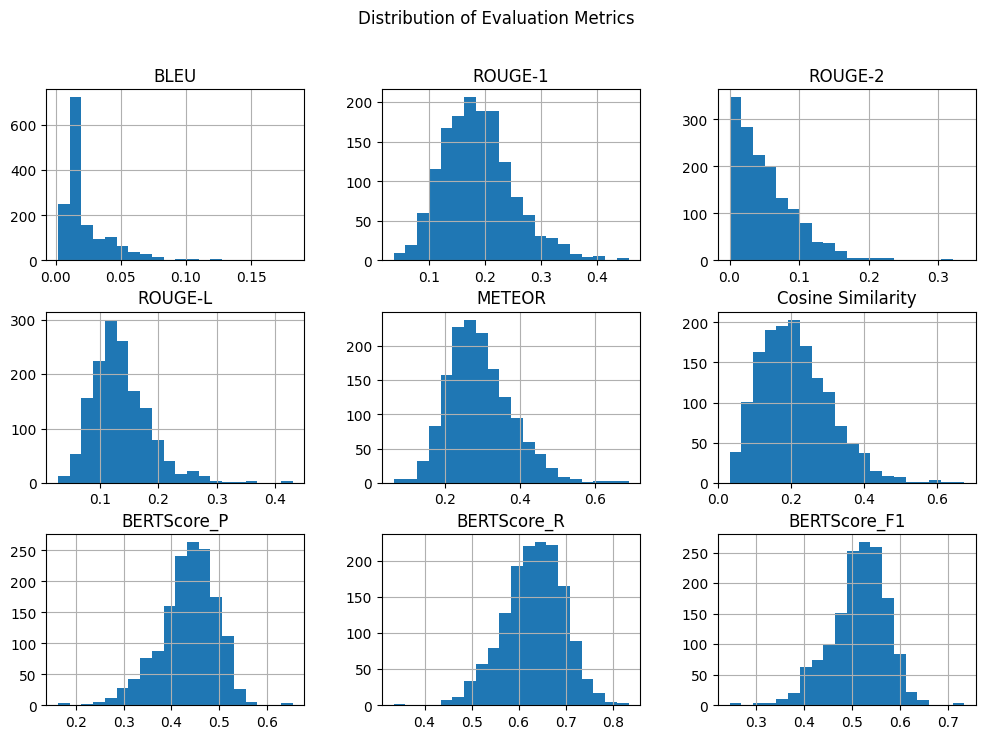

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']])
plt.title('Evaluation Metrics for BART Model on DialogSum Test Data')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()

# Histograms
results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Evaluation Metrics')
plt.show()


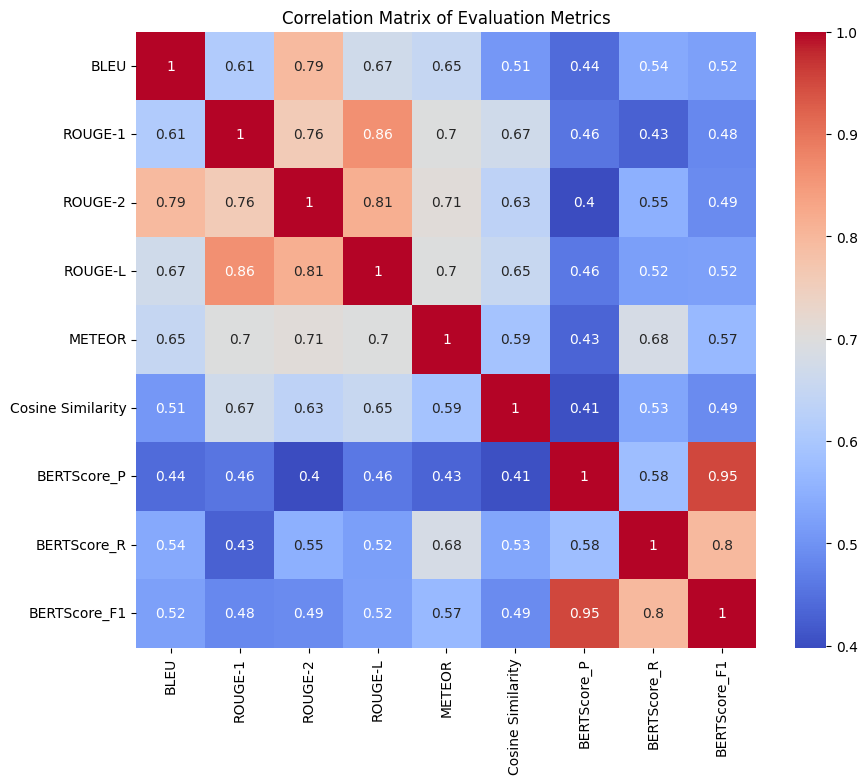

In [ ]:
#correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Evaluation Metrics')
plt.show()

**FINE TUNING BART MODEL USING OPTUNA**

In [ ]:
pip install transformers datasets torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from datasets import load_dataset
dataset_ft = load_dataset("knkarthick/dialogsum")
train_dataset_ft = dataset_ft['train']
val_dataset = dataset_ft['validation']
test_dataset = dataset_ft['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
def find_duplicates(dataset, column_name):
    duplicates = dataset.filter(lambda example: dataset[column_name].count(example[column_name]) > 1)
    return duplicates

In [ ]:
from transformers import BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
#tokenizing the inputs and labels
def preprocess_function(examples):
    inputs = ["summarize: " + dialogue for dialogue in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    #Tokenizing the summaries
    labels = tokenizer(examples["summary"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

train_dataset = train_dataset_ft.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [ ]:
'''
import optuna
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    num_train_epochs = trial.suggest_int('num_train_epochs', 1, 3)

    training_args = Seq2SeqTrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_total_limit=3,
        num_train_epochs=num_train_epochs,
        predict_with_generate=True,
        logging_dir='./logs',
        logging_steps=10,
        report_to="none"
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer
    )

    trainer.train()
    eval_results = trainer.evaluate(eval_dataset=val_dataset)
    return eval_results['eval_loss']
'''

In [ ]:
import optuna
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    num_train_epochs = trial.suggest_int('num_train_epochs', 1, 3)

    # configuration updated with generation parameters
    model.config.early_stopping = True
    model.config.num_beams = 4
    model.config.no_repeat_ngram_size = 3
    model.config.forced_bos_token_id = 0
    model.config.forced_eos_token_id = 2

    # define training arguments with suggested hyperparameters
    training_args = Seq2SeqTrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_total_limit=3,
        num_train_epochs=num_train_epochs,
        predict_with_generate=True,
        logging_dir='./logs',
        logging_steps=10,
        report_to="none"
    )

    #initializing the trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer
    )


    trainer.train()
    eval_results = trainer.evaluate(eval_dataset=val_dataset, metric_key_prefix="eval")
    return eval_results['eval_loss']

In [ ]:
# study creation and optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best hyperparameters: ", study.best_params)
print("Best validation loss: ", study.best_value)

[I 2024-08-12 15:21:28,434] A new study created in memory with name: no-name-429dd4b4-f324-4f85-a304-398c7e0b9b50
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.284900,0.269040
2,0.311900,0.265932
3,0.257100,0.265844


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 15:45:51,063] Trial 0 finished with value: 0.26584404706954956 and parameters: {'learning_rate': 1.2600030412799649e-05, 'batch_size': 16, 'weight_decay': 2.8158030071978654e-06, 'num_train_epochs': 3}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy`

Epoch,Training Loss,Validation Loss
1,0.251400,0.268259
2,0.270700,0.266518
3,0.227300,0.265942


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 16:10:18,272] Trial 1 finished with value: 0.26594218611717224 and parameters: {'learning_rate': 2.55875480740906e-05, 'batch_size': 16, 'weight_decay': 0.00742583647006777, 'num_train_epochs': 3}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is d

Epoch,Training Loss,Validation Loss
1,0.189800,0.283514
2,0.221200,0.281178
3,0.211600,0.275699


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 16:34:41,331] Trial 2 finished with value: 0.275698721408844 and parameters: {'learning_rate': 1.8969300632773935e-05, 'batch_size': 16, 'weight_decay': 0.0022400575806854894, 'num_train_epochs': 3}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is

Epoch,Training Loss,Validation Loss
1,0.223400,0.275583


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Epoch,Training Loss,Validation Loss
1,0.223400,0.275583
2,0.260800,0.276934


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 16:53:07,076] Trial 3 finished with value: 0.2769339978694916 and parameters: {'learning_rate': 2.4251739472478966e-05, 'batch_size': 8, 'weight_decay': 0.0026296165272218677, 'num_train_epochs': 2}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is

Epoch,Training Loss,Validation Loss
1,0.135900,0.313379


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


[I 2024-08-12 17:01:21,090] Trial 4 finished with value: 0.3133793771266937 and parameters: {'learning_rate': 1.047635814655354e-05, 'batch_size': 16, 'weight_decay': 4.101316651343797e-06, 'num_train_epochs': 1}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is

Epoch,Training Loss,Validation Loss
1,0.172600,0.307645


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 17:10:39,097] Trial 5 finished with value: 0.30764469504356384 and parameters: {'learning_rate': 4.6124539611999006e-05, 'batch_size': 8, 'weight_decay': 0.006026301518432725, 'num_train_epochs': 1}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is

Epoch,Training Loss,Validation Loss
1,0.176300,0.313967
2,0.243800,0.305400


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 17:29:01,118] Trial 6 finished with value: 0.30540019273757935 and parameters: {'learning_rate': 1.3937289686854634e-05, 'batch_size': 8, 'weight_decay': 6.807417465477866e-05, 'num_train_epochs': 2}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` i

Epoch,Training Loss,Validation Loss
1,0.157900,0.353159


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 17:38:13,398] Trial 7 finished with value: 0.3531585931777954 and parameters: {'learning_rate': 7.288868066829987e-05, 'batch_size': 8, 'weight_decay': 6.891008862114015e-05, 'num_train_epochs': 1}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is 

Epoch,Training Loss,Validation Loss
1,0.156700,0.358058
2,0.239000,0.314071
3,0.163600,0.312822


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 18:05:40,858] Trial 8 finished with value: 0.31282171607017517 and parameters: {'learning_rate': 1.0688360381629712e-05, 'batch_size': 8, 'weight_decay': 0.002665082862848322, 'num_train_epochs': 3}. Best is trial 0 with value: 0.26584404706954956.
<ipython-input-13-44ae86ff5f1f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-13-44ae86ff5f1f>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is

Epoch,Training Loss,Validation Loss
1,0.135100,0.378096
2,0.220200,0.327637
3,0.150700,0.324767


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

[I 2024-08-12 18:33:08,990] Trial 9 finished with value: 0.3247665762901306 and parameters: {'learning_rate': 4.01920138010684e-05, 'batch_size': 8, 'weight_decay': 0.0011465179364070438, 'num_train_epochs': 3}. Best is trial 0 with value: 0.26584404706954956.


Best hyperparameters:  {'learning_rate': 1.2600030412799649e-05, 'batch_size': 16, 'weight_decay': 2.8158030071978654e-06, 'num_train_epochs': 3}
Best validation loss:  0.26584404706954956


In [ ]:
best_params = study.best_params
best_params

{'learning_rate': 1.2600030412799649e-05,
 'batch_size': 16,
 'weight_decay': 2.8158030071978654e-06,
 'num_train_epochs': 3}

{'learning_rate': 1.2600030412799649e-05,
 'batch_size': 16,
 'weight_decay': 2.8158030071978654e-06,
 'num_train_epochs': 3}

In [ ]:
#training arguments set with the best hyperparameters
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    weight_decay=best_params['weight_decay'],
    save_total_limit=3,
    num_train_epochs=best_params['num_train_epochs'],
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#initializing the trainer with the best hyperparameters
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.117600,0.348173
2,0.131300,0.347230
3,0.134400,0.342734


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=2337, training_loss=0.09954860825593725, metrics={'train_runtime': 1452.1967, 'train_samples_per_second': 25.74, 'train_steps_per_second': 1.609, 'total_flos': 1.13959744045056e+16, 'train_loss': 0.09954860825593725, 'epoch': 3.0})

In [ ]:
#saving model
import torch
torch.save(model.state_dict(), "fine-tuned-bart.pt")

In [ ]:
model.save_pretrained("./fine-tuned-bart")
tokenizer.save_pretrained("./fine-tuned-bart")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('./fine-tuned-t5/tokenizer_config.json',
 './fine-tuned-t5/special_tokens_map.json',
 './fine-tuned-t5/vocab.json',
 './fine-tuned-t5/merges.txt',
 './fine-tuned-t5/added_tokens.json')

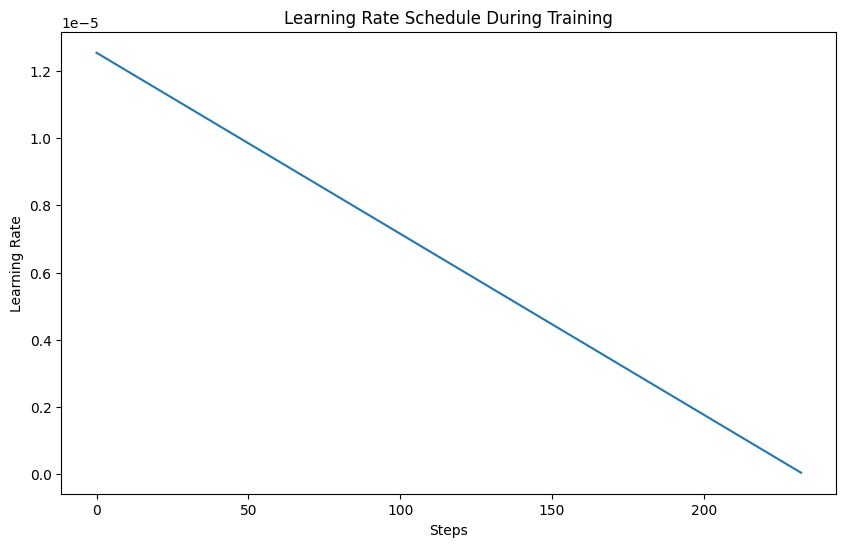

In [ ]:
import matplotlib.pyplot as plt
learning_rates = [entry['learning_rate'] for entry in trainer.state.log_history if 'learning_rate' in entry]
steps = range(len(learning_rates))

plt.figure(figsize=(10, 6))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule During Training")
plt.show()

#FINE - TUNING USING PARAMETERS FROM OPTUNA

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requir

In [ ]:
from datasets import load_dataset

# Loading the DialogSum dataset
dataset_ft = load_dataset("knkarthick/dialogsum")
train_dataset_ft = dataset_ft['train']
val_dataset = dataset_ft['validation']
test_dataset = dataset_ft['test']

In [ ]:
print(dataset_dialog)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12458
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


In [ ]:
seen_dialogues = set()

def filter_duplicates(record):
    dialogue = record['dialogue']
    if dialogue in seen_dialogues:
        return False
    else:
        seen_dialogues.add(dialogue)
        return True

# Apply the filter to the dataset
dataset_dialog['train'] = dataset_dialog['train'].filter(filter_duplicates)


Filter:   0%|          | 0/12458 [00:00<?, ? examples/s]

In [ ]:
import torch
import time
import os
import psutil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cuda


In [ ]:
'''
import warnings
warnings.filterwarnings("ignore")'''

In [ ]:
from transformers import BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [ ]:
def preprocess_function(records):
    inputs = ["summarize: " + dialogue for dialogue in records["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(records["summary"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset_ft.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
# Training the model again with the fine tuning parameters given by Optuna as .pt
#file of model could not be saved earlier
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate= 1.2600030412799649e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay= 2.8158030071978654e-06,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

start_time = time.time()
trainer.train()
elapsed_time = time.time()

Epoch,Training Loss,Validation Loss
1,0.330300,0.291987
2,0.357700,0.277379
3,0.298900,0.275530


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

In [ ]:
pip install pynvml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 883.4 kB/s eta 0:00:00


In [ ]:
import pynvml
pynvml.nvmlInit()
elapsed_time = time.time() - start_time
def log_gpu_utilization():
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory total: {info.total / 1024**2:.2f} MB")
    print(f"GPU memory allocated: {info.used / 1024**2:.2f} MB")
    print(f"GPU memory free: {info.free / 1024**2:.2f} MB")
print(f"Training completed in {elapsed_time:.2f} seconds")
log_gpu_utilization()

Training completed in 1101.32 seconds
GPU memory total: 40960.00 MB
GPU memory allocated: 11729.19 MB
GPU memory free: 29230.81 MB


In [ ]:
torch.save(model.state_dict(), "fine-tuned-BART.pt")

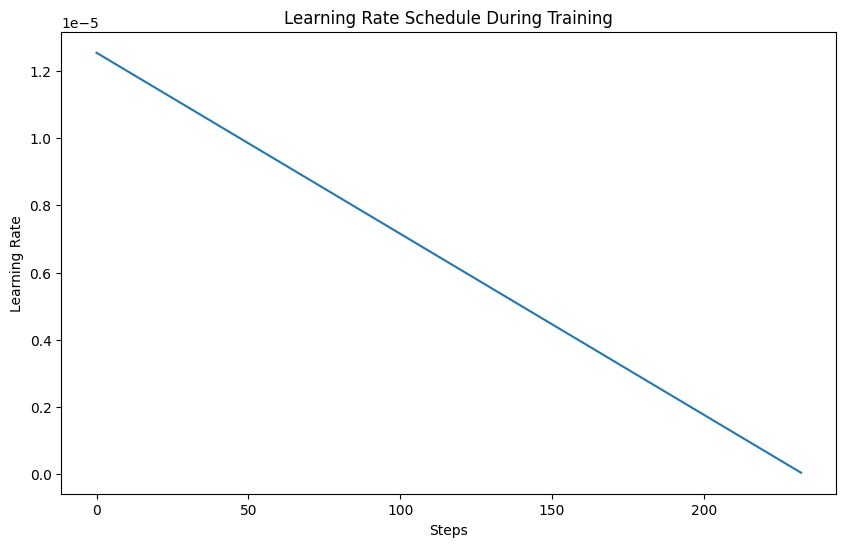

In [ ]:
import matplotlib.pyplot as plt

learning_rates = [entry['learning_rate'] for entry in trainer.state.log_history if 'learning_rate' in entry]
steps = range(len(learning_rates))

plt.figure(figsize=(10, 6))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule During Training")
plt.show()

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7d80a5ef20532c69e4ee95642c4a4f20537be0ba9dc7f34ad816ecea7e3b1fa1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install bert-score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import nltk
from transformers import BartTokenizer, BartForConditionalGeneration, GenerationConfig
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model.load_state_dict(torch.load("/content/fine-tuned-BART.pt"))
model.eval()
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

In [ ]:
generation_config = GenerationConfig(
    early_stopping=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    forced_bos_token_id=0,
    forced_eos_token_id=2
)
def generate_summary_batch(records):
    input_texts = records['dialogue']
    input_ids = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)

    with torch.no_grad():
        output_ids = model.generate(input_ids['input_ids'].to(device), max_length=150, generation_config=generation_config)

    summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in output_ids]
    return {"generated_summary": summaries}

test_dataset = test_dataset.map(generate_summary_batch, batched=True, batch_size=8)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
def calculate_metrics(reference, hypothesis):
    metrics = {}

    # Tokenizing reference and summaries for METEOR,BLEU
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    # BLEU
    smooth_fn = SmoothingFunction().method1
    metrics['BLEU'] = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1'] = rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2'] = rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L'] = rouge_scores['rougeL'].fmeasure
    # METEOR
    metrics['METEOR'] = meteor_score([reference_tokens], hypothesis_tokens)
    # BERTScore
    P, R, F1 = bert_score([hypothesis], [reference], lang='en', model_type='bert-base-uncased', verbose=False)
    metrics['BERTScore_P'] = P.mean().item()
    metrics['BERTScore_R'] = R.mean().item()
    metrics['BERTScore_F1'] = F1.mean().item()
    # Cosine
    vectorizer = TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]
    return metrics

test_results = test_dataset.map(lambda example: calculate_metrics(example['summary'], example['generated_summary']))

results_df = pd.DataFrame(test_results)
print(f"Evaluation Metrics for BART Model\n") #the ft one
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'Cosine Similarity', 'BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluation Metrics for BART Model

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.155330     0.435671     0.174386     0.351774     0.433705   
std       0.134543     0.148961     0.156184     0.152866     0.161588   
min       0.006259     0.105263     0.000000     0.065574     0.088757   
25%       0.059088     0.333333     0.060606     0.242424     0.316097   
50%       0.106449     0.421053     0.140351     0.324324     0.413921   
75%       0.220602     0.521739     0.250000     0.428571     0.535714   
max       1.000000     1.000000     1.000000     1.000000     0.999711   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.345532     0.693049     0.715102      0.702200  
std             0.150325     0.096285     0.082991      0.083450  
min             0.033754     0

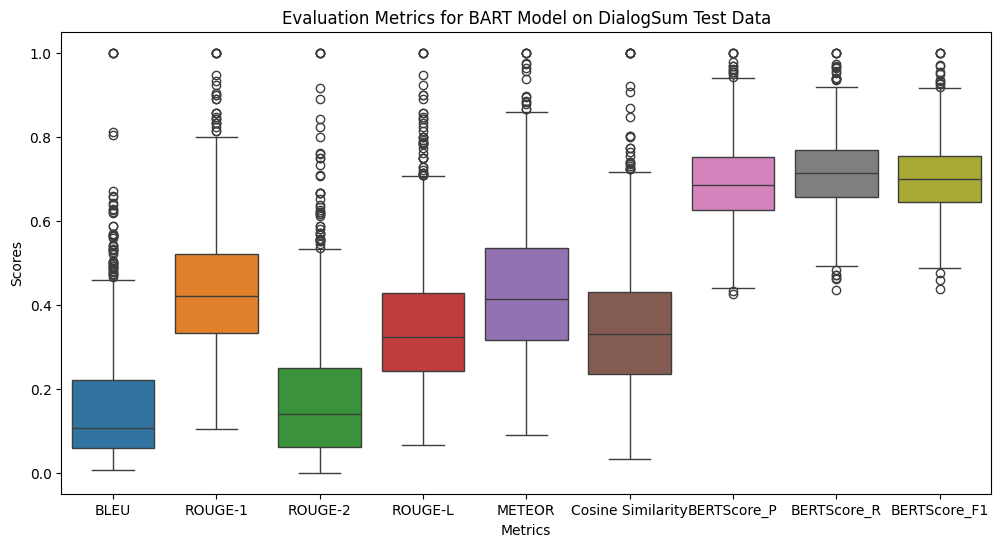

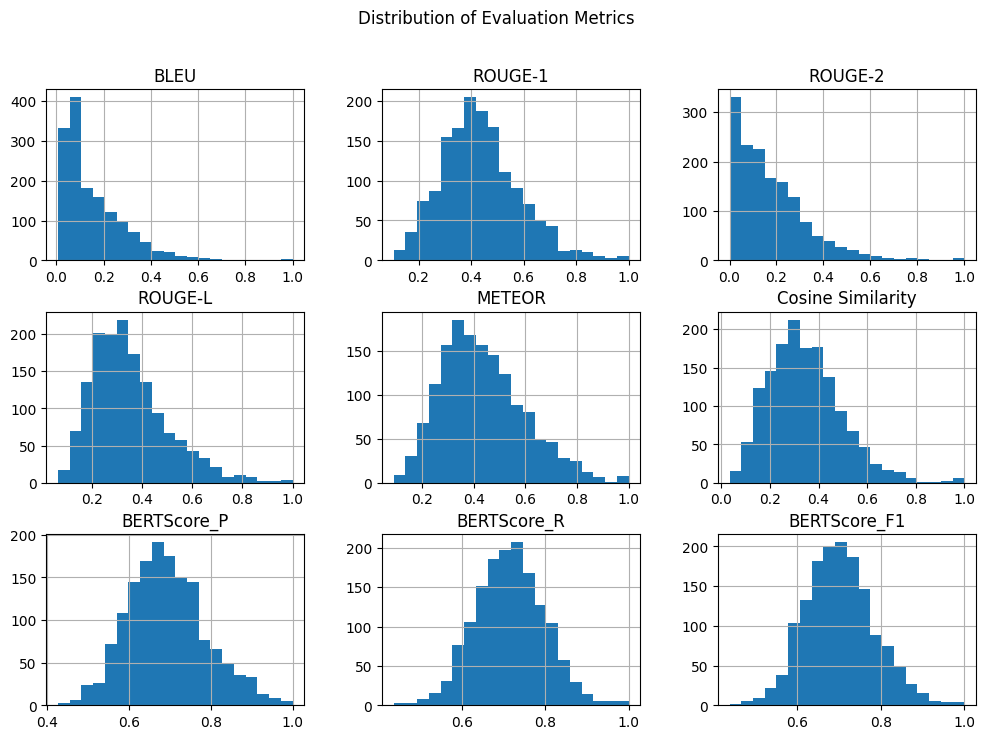

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']])
plt.title('Evaluation Metrics for BART Model on DialogSum Test Data')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()
# Histogram
results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Evaluation Metrics')
plt.show()


In [ ]:
for i in range(6):
    print(f"\nExample {i+1}:")
    print(f"Original Summary: {test_dataset[i]['summary']}")
    print(f"Generated Summary: {test_dataset[i]['generated_summary']}")



Example 1:
Original Summary: Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.
Generated Summary: Ms. Dawson asks #Person1# to take a dictation for an intra-office memorandum to all employees by this afternoon. #Person2# tells Ms. Dawson the new policy applies to internal and external communications and will be placed on probation.

Example 2:
Original Summary: In order to prevent employees from wasting time on Instant Message programs, #Person1# decides to terminate the use of those programs and asks Ms. Dawson to send out a memo to all employees by the afternoon.
Generated Summary: Ms. Dawson asks #Person1# to take a dictation for an intra-office memorandum to all employees by this afternoon. #Person2# tells Ms. Dawson the new policy applies to internal and external communications and will be placed on probation.

Example 3:
Original Summary: Ms. Dawson takes a dictation